# Two-Layer Networks on CIFAR10, Cyclical Learning Rate Schedule, and Bayesian Hyperparameter Search

## Contents

* [Introduction](#introduction)
* [Imports](#imports)
* [Importing Dataset and Data Pre-Processing](#importing-dataset-and-data-pre-processing)
* [Numerical Gradient Check](#numerical-gradient-check)
* [Training and Results](#training-and-results)
* [Hyperparameter Search](#hyperparameter-search)

## Introduction <a class="anchor" id="introduction"></a>

In this notebook, a two-layer network with multiple outputs is trained and tested to classify images from the CIFAR-10 dataset. The network is trained using mini-batch gradient descent applied to a cost function that computes the cross-entropy loss of the classifier applied to the labelled training data and an L2 regularization term on the weight matrix. The learning rate uses a cyclical learning rate schedule. Furthemore, a Bayesian hyperparameter search is conducted with the use of external libraries.

In my implementation, I built on top of the code presented in the ```one-layer.ipynb``` notebook. At the core of my implementation is the ```Dense``` layer (fully-connected layer that can have activations ```SoftmaxActivation```, ```LinearActivation```, and ```ReLUActivation```. The learnable (or trainable) parameters of the ```Dense``` layer can be initialized with the ```XavierInitializer```, and can be regularized with the ```L2Regularizer```. A ```Model``` comprises any number of layers, its loss function is ```CategoricalCrossEntropyLoss```. The trainable parameters are optimized with the mini-batch gradient descent algorithm via the ```SGDOptimizer``` and the learning rate schedule of the optimizer is [```LRCyclingSchedule```](https://arxiv.org/abs/1506.01186) . The ```Model``` is first compiled with the loss function, some metrics such as the ```AccuracyMetrics```, and the optimizer, and then it is fit to the data with the ```Model.fit``` method.

In this notebook, I implemented a two-layer neural network for multi-class classification such that both of the ```Dense``` layers' trainable parameters are initialized with the ```XavierInitializer``` and regularized with the ```L2Regularizer```. The input dimension and the output dimension of the first ```Dense``` layer are 3072 (=32x32x3) and 50, respectively. The input and output dimensions of the second ```Dense``` layer are 50 and 10 (=the number of class labels), respectively. The first ```Dense``` layer has ```ReLUActivation```, and the second ```Dense``` layer has ```SoftmaxActivation```. The ```Model``` is then compiled with the ```CategoricalCrossEntropyLoss``` loss function, the ```AccuracyMetrics``` performance metric, and the ```SGDOptimizer``` optimizer that uses the ```LRCyclingSchedule``` learning rate schedule.

## Imports <a class="anchor" id="imports"></a>

Import the library parts and the required packages.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import pickle
from copy import deepcopy
from math import sqrt, ceil
import datetime
import time
import sys
from itertools import product
import pandas as pd
from hyperopt import hp, fmin, tpe, space_eval, STATUS_OK, Trials


from data_utils import load_cfar10_batch, load_label_names
from losses import CategoricalCrossEntropyLoss, LossSmootherConstant
from activations import LinearActivation, ReLUActivation, SoftmaxActivation
from initializers import NormalInitializer, XavierInitializer
from layers import Dense
from regularizers import L2Regularizer
from models import Model
from metrics import AccuracyMetrics
from optimizers import SGDOptimizer
from opt_utils import GradClipperByNothing
from lr_schedules import LRConstantSchedule, LRExponentialDecaySchedule, LRCyclingSchedule
from viz_utils import plot_losses, plot_costs, plot_accuracies, plot_lrs
from grad_check import numerical_gradient_check_model

## Importing Dataset and Data Pre-Processing <a class="anchor" id="importing-dataset-and-data-pre-processing"></a>

In this notebook, for the sake of speed, the training set is ```data_batch_1```, the validation set is ```data_batch_2```, and the test set is ```test_batch```.

Pre-process datasets by standardization of features (subtract mean of each feature and divide by its standard deviation). Use the training mean and standard deviation on the validation and the test datasets! After this, the mean of each feature in the subsets should be around 0 and the standard deviation should be around 1.

For a finer breakdown of these steps, see ```one-layer.ipynb```.

In [2]:
# train set is batch 1, val set is batch 2, test set is test
path = os.path.join("data", "data_batch_1")
x_train_img, y_train = load_cfar10_batch(path)

path = os.path.join("data", "data_batch_2")
x_val_img, y_val = load_cfar10_batch(path)

path = os.path.join("data", "test_batch")
x_test_img, y_test = load_cfar10_batch(path)

print(f"There are {np.unique(y_train).size} labels which are: \n{np.unique(y_train)}")

# check counts in datasets
print(f"The images are of shape: {x_train_img.shape[1:]}")
print(f"The set sizes are train: {x_train_img.shape[0]}, "
      f"validation: {x_val_img.shape[0]}, and test: {x_test_img.shape[0]}")

# assert balanced dataset
train_counts = np.unique(y_train, return_counts=True)[1]
train_ratios = train_counts / train_counts.sum()

val_counts = np.unique(y_val, return_counts=True)[1]
val_ratios = val_counts / val_counts.sum()

test_counts = np.unique(y_test, return_counts=True)[1]
test_ratios = test_counts / test_counts.sum()

# This is approximating the ratios, good enough
np.testing.assert_allclose(train_ratios, val_ratios, rtol=1e-1, atol=0)
np.testing.assert_allclose(val_ratios, test_ratios, rtol=1e-1, atol=0)

print(f"The class ratios in the training set are: {train_ratios}")
print(f"The class ratios in the validation set are: {val_ratios}")
print(f"The class ratios in the test set are: {test_ratios}")

x_train_un = x_train_img.reshape(x_train_img.shape[0], -1)
x_val_un = x_val_img.reshape(x_val_img.shape[0], -1)
x_test_un = x_test_img.reshape(x_test_img.shape[0], -1)

#x_train = x_train_un / 255.
#x_val = x_val_un / 255.
#x_test = x_test_un / 255.

mean = np.mean(x_train_un, axis=0).reshape(1, x_train_un.shape[1])
std = np.std(x_train_un, axis=0).reshape(1, x_train_un.shape[1])

x_train = (x_train_un - mean) / std
x_val = (x_val_un - mean) / std
x_test = (x_test_un - mean) / std

print(f"The means of the training set: {np.mean(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")
print(f"The stds of the training set: {np.std(x_train, axis=0)} "
      f"(#features = {np.mean(x_train, axis=0).size})")

print(f"The means of the validation set: {np.mean(x_val, axis=0)}")
print(f"The stds of the validation set: {np.std(x_val, axis=0)}")

print(f"The means of the test set: {np.mean(x_test, axis=0)}")
print(f"The stds of the test set: {np.std(x_test, axis=0)}")

There are 10 labels which are: 
[0 1 2 3 4 5 6 7 8 9]
The images are of shape: (32, 32, 3)
The set sizes are train: 10000, validation: 10000, and test: 10000
The class ratios in the training set are: [0.1005 0.0974 0.1032 0.1016 0.0999 0.0937 0.103  0.1001 0.1025 0.0981]
The class ratios in the validation set are: [0.0984 0.1007 0.101  0.0995 0.101  0.0988 0.1008 0.1026 0.0987 0.0985]
The class ratios in the test set are: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
The means of the training set: [ 1.31672451e-16  5.32907052e-18  3.59934305e-17 ... -1.10966791e-16
 -1.01096909e-16  2.62401212e-17] (#features = 3072)
The stds of the training set: [1. 1. 1. ... 1. 1. 1.] (#features = 3072)
The means of the validation set: [-0.02151247 -0.01731957 -0.01718778 ... -0.00928345 -0.00494739
 -0.00583879]
The stds of the validation set: [0.9972366  0.99489016 0.99599598 ... 0.99822343 0.98979069 0.99003225]
The means of the test set: [-0.01997713 -0.01194233 -0.00644388 ... -0.01584402 -0.0069629

## Numerical Gradient Check <a class="anchor" id="numerical-gradient-check"></a>

The correctness of the gradient computation and backpropagation was assured via numerical gradient check. I implemented the double centered gradient check with the ```numerical_gradient_check_model``` that computes the analytical and numerical gradients, and then compares them in each layer in the model. As outlined in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck), it is satisfactory to assert that the analytical gradients of the model are correct based on the values shwon below . To avoid kinks in the objective function, only a few data points were used in the gradient check. The step size for computing the numerical gradient was set to 1e-06. In computing the relative error, the formula provided in [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/neural-networks-3/#gradcheck) was used. Furthermore, the ```numpy.testing.assert\_array\_almost\_equal``` function was also used to make the comparison.

In [3]:
def build_model(reg_rate_l2, in_dim, mid_dim, out_dim, seed):
    
    # kernel and bias initializer params, normal distribution with Xavier os std is None (adaptively computed)
    init_params = {"coeff": 1.0, "mean": 0.0, "std": None}

    # define the dense layer
    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **init_params), 
              bias_initializer=XavierInitializer(seed=seed+1, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **init_params), 
              bias_initializer=XavierInitializer(seed=seed+3, **init_params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)

    # define the loss
    loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())
    
    return model, loss


def test_model(x, y, seed=6):
    in_dim = x.shape[1]
    mid_dim = 50
    out_dim = np.unique(y_train).size

    build_model_loss_func_dict = {
        "model": build_model
    }

    np.random.seed(seed + 3)
    reg_rates = 10e-2 * np.random.randint(low=1, high=10, size=5)

    for reg_rate in reg_rates:
        for key, build_model_func in build_model_loss_func_dict.items():
            print(f"network with reg. rate = {reg_rate:.4f}")
            model, loss = build_model_func(reg_rate, in_dim, mid_dim, out_dim, seed)
            numerical_gradient_check_model(x, y, model, loss)
            print()
            
test_model(x_train[:2, :10], y_train[:2])

network with reg. rate = 0.6000
layer=0, param_name=w
max rel error=8.604779596268731e-07
layer=0, param_name=b
max rel error=6.4432917294973935e-09
layer=1, param_name=w
max rel error=8.890298402076154e-08
layer=1, param_name=b
max rel error=3.840511462274298e-09
test_grad_check passed

network with reg. rate = 0.7000
layer=0, param_name=w
max rel error=1.9550366957949666e-07
layer=0, param_name=b
max rel error=6.4432917294973935e-09
layer=1, param_name=w
max rel error=1.6942324342327626e-07
layer=1, param_name=b
max rel error=3.840511462274298e-09
test_grad_check passed

network with reg. rate = 0.9000
layer=0, param_name=w
max rel error=3.700825705542563e-07
layer=0, param_name=b
max rel error=6.4432917294973935e-09
layer=1, param_name=w
max rel error=1.47348804853943e-07
layer=1, param_name=b
max rel error=3.840511462274298e-09
test_grad_check passed

network with reg. rate = 0.7000
layer=0, param_name=w
max rel error=1.9550366957949666e-07
layer=0, param_name=b
max rel error=6.443

## Training and Results <a class="anchor" id="training-and-results"></a>

A two-layer network is trained with ReLu activations, Xavier initilaization, L2 regularization, and a cyclical learning rate schedule.

The training data is ```data_batch_1```, the validation data is ```data_batch_2```, and the testing data is ```test_batch```. All of the training, validation, and test set included 10000 images. The data was pre-processed as described earlier. For the cyclical learning rate schedule, we need the number of data points in the training set.  

The ```LRCyclingSchedule``` cyclical learning rate schedule's base learning rate was 1e-5 and the maximum learning rate was 1e-1. The step size (half-cycle) of the ```LRCyclingSchedule``` was n\_s = 800 (i.e.: one fully cycle is 1600 steps). The training on the training set of 10000 images went on for 48 epochs with a mini-batch size of 100 that is equivalent to 48 000 / 100 = 4800 update steps, or equivalently for 3 full-cycles.

In [4]:
batch_size = 100

step_size = int(8*np.floor(x_train.shape[0] / batch_size))
print(f"step size of cyc. lr: {step_size} update steps")

cycle_steps = 2*step_size
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 3
n_epochs = int(n_cycle*epochs_one_full_cycle)
print(f"{n_cycle} cycle = {n_epochs} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 800 update steps
full cycle of cyc.lr : 1600 update steps
16.0 epochs = 1 full cycle = 1600 update steps
3 cycle = 48 epochs = 4800 update steps


model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 2.5000e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 2.5000e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with cycling lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 72.12it/s]
epoch 1/48 
 	 -- train loss = 1.877934537240929 / train cost = 2.6066589455396585
	 -- {"accuracy_train": 0.3417} 
	 -- val loss = 1.93937876576476 / val cost = 2.6681031740634893
	 -- {"accuracy_val": 0.3172} 


starting epoch: 2 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 72.09it/s]
epoch 2/48 
 	 -- train loss = 1.686525858267782 / train cost = 2.3

batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 63.50it/s]
epoch 26/48 
 	 -- train loss = 1.2589578465182971 / train cost = 1.5127400187862357
	 -- {"accuracy_train": 0.5639} 
	 -- val loss = 1.6234433640083938 / val cost = 1.8772255362763324
	 -- {"accuracy_val": 0.432} 


starting epoch: 27 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 63.68it/s]
epoch 27/48 
 	 -- train loss = 1.2305698445653181 / train cost = 1.4912248658394298
	 -- {"accuracy_train": 0.5772} 
	 -- val loss = 1.5987669614216513 / val cost = 1.859421982695763
	 -- {"accuracy_val": 0.4442} 


starting epoch: 28 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 72.59it/s]
epoch 28/48 
 	 -- train loss = 1.1762081238092186 / train cost = 1.4410945977345335
	 -- {"accuracy_train": 0.5994} 
	 -- val loss = 1.5676381237532242 / val cost = 1.8325245976785391
	 -- {"accuracy_val": 0.4568} 


starting epoch: 29 ...
batch 100/100: 100%|██████████| 100/100 [00:01<00:00, 70.14it/s]
epoch 29/48 
 	 -- 

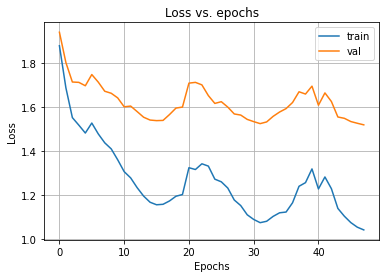

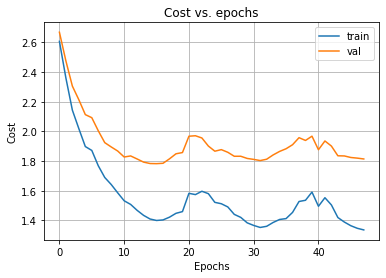

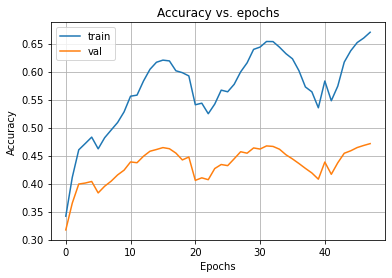

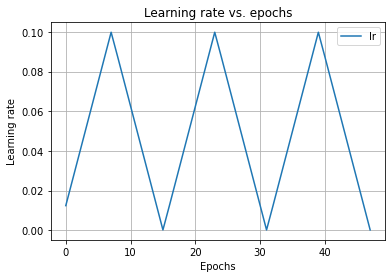

The test metrics are: {'accuracy': 0.4832}


In [5]:
coeff = 1.0
mean = 0.0
std = 0.01
params = {"coeff":coeff, "mean": mean, "std":None}

reg_rate_l2 = 0.025

in_dim = x_train.shape[1]
out_dim = np.unique(y_train).size
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)

loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())

# defined before
# n_epochs = 48
# batch_size = 100

lr_initial = 1e-5
lr_max = 1e-1
# defined before
# step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule, grad_clipper=GradClipperByNothing())

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

# verbosity level of fit
verbose = 2
history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, None)

path_save_losses = "assets/two_layer/losses.png"
path_save_costs = "assets/two_layer/costs.png"
path_save_accuracies = "assets/two_layer/accuracies.png"
path_save_lrs = "assets/two_layer/lrs.png"
plot_losses(history, path_save_losses)
plot_costs(history, path_save_costs)
plot_accuracies(history, path_save_accuracies)
plot_lrs(history, path_save_lrs)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"The test metrics are: {metrics_test}")

Note that the reason for the learning rate curve to be shifted is that the learning rate is always recorded at the end of an epoch.

As shown in the results, the cylcial learning rate schedule increases and decrease the learning rate in cycles. This helps escape local minimia during optimization and achieve better model performance.

Let's see some of the correct and incorrect predicitions of the trained model.

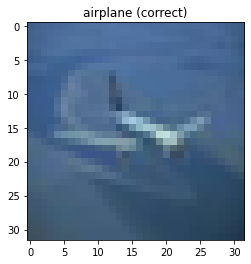

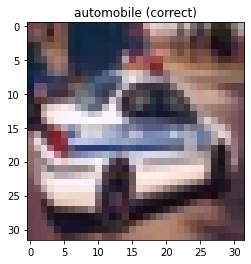

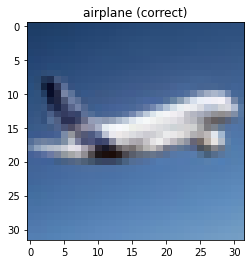

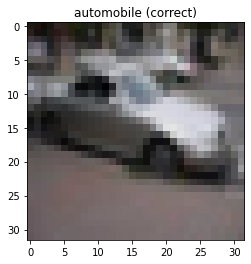

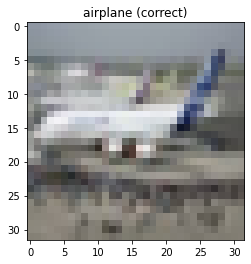

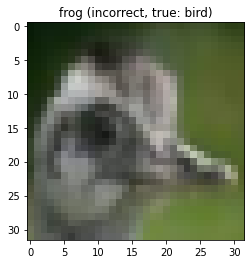

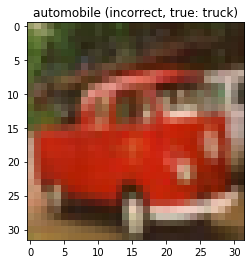

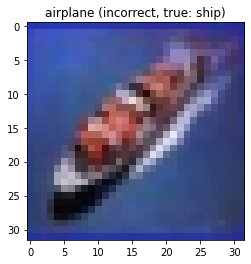

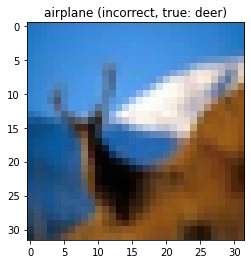

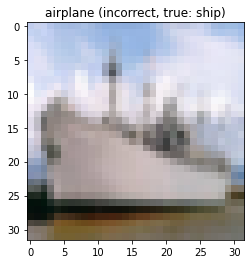

In [6]:
label_names = load_label_names()
correct_preds_indices = np.argwhere(y_hat_test == y_test).flatten()
incorrect_preds_indices = np.argwhere(y_hat_test != y_test).flatten()
np.random.seed(123)
np.random.shuffle(correct_preds_indices)
np.random.seed(123)
np.random.shuffle(incorrect_preds_indices)

for preds_idx in np.hstack([correct_preds_indices[:5], incorrect_preds_indices[:5]]):
    plt.imshow(x_test_img[preds_idx])
    
    pred_label = label_names[y_hat_test[preds_idx]]
    true_label = label_names[y_test[preds_idx]]
    title = \
        f"{pred_label} (correct)" \
        if pred_label == true_label \
        else f"{pred_label} (incorrect, true: {true_label})"
    plt.title(title) 
    plt.show()

## Hyperparameter Search <a class="anchor" id="hyperparameter-search"></a>

The hyperparameter search is conducted for the combination of two hyperpaparameters - the learning rate and the L2 regularization strength. To do that, [hyperopt](#https://github.com/hyperopt/hyperopt), a Bayesian, distributed hyperparameter optimization library is used.

In [7]:
def objective(x_train, y_train, x_val, y_val, **kwargs):
    
    reg_rate_l2 = kwargs["reg_rate_l2"]
    lr_initial = kwargs["lr_initial"]

    params = {"coeff": 1.0, "mean": 0.0, "std":None}

    in_dim = x_train.shape[1]
    out_dim = np.unique(y_train).size
    mid_dim = 50

    seed = 200

    dense_1 = \
        Dense(in_dim=in_dim, out_dim=mid_dim, 
              kernel_initializer=XavierInitializer(seed=seed, **params), 
              bias_initializer=XavierInitializer(seed=seed+1, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=ReLUActivation()
             )

    dense_2 = \
        Dense(in_dim=mid_dim, out_dim=out_dim,
              kernel_initializer=XavierInitializer(seed=seed+2, **params), 
              bias_initializer=XavierInitializer(seed=seed+3, **params), 
              kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
              activation=SoftmaxActivation()
             )

    layers = [
        dense_1,
        dense_2
    ]

    model = Model(layers)

    loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())

    # as defined from before
    n_epochs = 48
    batch_size = 100

    # lr_initial = 1e-5
    lr_max = 1e-1
    
    # as defined from before
    step_size = 800
    lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
    optimizer = SGDOptimizer(lr_schedule=lr_schedule, grad_clipper=GradClipperByNothing())

    metrics = [AccuracyMetrics()]

    model.compile_model(optimizer, loss, metrics)
    print(model)

    # verbosity level of fit
    verbose = 1
    history = model.fit(x_train, y_train, x_val, y_val, n_epochs, batch_size, verbose, aug_func=None)

    params_val = {"mode": "test"}
    scores_val = model.forward(x_val, **params_val)
    y_hat_val = np.argmax(scores_val, axis=1)
    metrics_val = model.compute_metrics(y_val, scores_val)
    print(f"val acc: {metrics_val}, with lr_initial={lr_initial}, reg_rate_l2={reg_rate_l2}")
    val_acc = metrics_val['accuracy']

    return {
        'loss': -val_acc,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'val_acc': val_acc,
        'reg_rate_l2': reg_rate_l2,
        'lr_initial': lr_initial
    }


def run_trials(x_train, y_train, x_val, y_val, pickle_saved_path):
    # how many additional trials to do after loading saved trials. 1 = save after iteration
    trials_step = 1
    # initial max_trials. put something small to not have to wait
    max_trials = 2

    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open(pickle_saved_path, "rb"))
        print("Found saved Trials! Loading...")
        max_trials = len(trials.trials) + trials_step
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        trials = Trials()

    objective_lambda = lambda kwargs: objective(x_train, y_train, x_val, y_val, **kwargs)

    reg_rate_l2_limits = (1e-3, 0.5)
    lr_initial_limits = (1e-6, 0.9*1e-1)

    space = {
        "reg_rate_l2": hp.uniform("reg_rate_l2", reg_rate_l2_limits[0], reg_rate_l2_limits[1]),
        "lr_initial": hp.uniform("lr_initial", lr_initial_limits[0], lr_initial_limits[1]),
    }

    # max_evals = 2

    best = fmin(objective_lambda,
                space=space,
                algo=tpe.suggest,
                max_evals=max_trials,
                trials=trials)

    print("Best:", best)

    # save the trials object
    with open(pickle_saved_path, "wb") as f:
        pickle.dump(trials, f)


In [8]:
pickle_saved_path = "assets/two_layer/two_layer_hyperopt.hyperopt"
# loop indefinitely and stop whenever you like
run_for = 5
for i in range(run_for):
    run_trials(x_train, y_train, x_val, y_val, pickle_saved_path)

Found saved Trials! Loading...
Rerunning from 16 trials to 17 (+1) trials
model summary:                                         
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 1.2513e-01
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 1.2513e-01
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with cycling lr schedule and clipper who does nothing

starting epoch: 1 ...                                  
epoch 1/48                                             
 	 -- train loss = 1.7254762913021027 / train cost = 2.8827959978710385
	 -- {"accuracy_train": 0.3915} 
	 -- val loss = 1.8043602922021709 / val cost = 2.961679998771107
	 -- {"accuracy_val": 0.3558} 


starting epoch: 2 ...    

starting epoch: 25 ...                                 
epoch 25/48                                            
 	 -- train loss = 1.6721950882649643 / train cost = 1.880730375473798
	 -- {"accuracy_train": 0.4199} 
	 -- val loss = 1.7429604740811229 / val cost = 1.9514957612899564
	 -- {"accuracy_val": 0.3854} 


starting epoch: 26 ...                                 
epoch 26/48                                            
 	 -- train loss = 1.6799536860471294 / train cost = 1.8870248483968481
	 -- {"accuracy_train": 0.4091} 
	 -- val loss = 1.7630445281801568 / val cost = 1.9701156905298756
	 -- {"accuracy_val": 0.3743} 


starting epoch: 27 ...                                 
epoch 27/48                                            
 	 -- train loss = 1.6839635620921711 / train cost = 1.899467472365975
	 -- {"accuracy_train": 0.4003} 
	 -- val loss = 1.7555817002409098 / val cost = 1.9710856105147136
	 -- {"accuracy_val": 0.3678} 


starting epoch: 28 ...                             

starting epoch: 1 ...                                  
epoch 1/48                                             
 	 -- train loss = 1.9512864070094933 / train cost = 2.260535400044547
	 -- {"accuracy_train": 0.3182} 
	 -- val loss = 1.9750442401459993 / val cost = 2.284293233181053
	 -- {"accuracy_val": 0.2976} 


starting epoch: 2 ...                                  
epoch 2/48                                             
 	 -- train loss = 1.952461508265452 / train cost = 2.155795402148968
	 -- {"accuracy_train": 0.2991} 
	 -- val loss = 1.9765942371810967 / val cost = 2.1799281310646124
	 -- {"accuracy_val": 0.2794} 


starting epoch: 3 ...                                  
epoch 3/48                                             
 	 -- train loss = 1.9560332440903996 / train cost = 2.145195673496071
	 -- {"accuracy_train": 0.308} 
	 -- val loss = 1.9785809069406717 / val cost = 2.167743336346343
	 -- {"accuracy_val": 0.2937} 


starting epoch: 4 ...                                  


starting epoch: 27 ...                                 
epoch 27/48                                            
 	 -- train loss = 1.9537256469982611 / train cost = 2.130714675142792
	 -- {"accuracy_train": 0.3061} 
	 -- val loss = 1.975131678397928 / val cost = 2.1521207065424592
	 -- {"accuracy_val": 0.2904} 


starting epoch: 28 ...                                 
epoch 28/48                                            
 	 -- train loss = 1.9595899091686304 / train cost = 2.1212706432872213
	 -- {"accuracy_train": 0.3059} 
	 -- val loss = 1.9802434915059361 / val cost = 2.141924225624527
	 -- {"accuracy_val": 0.29} 


starting epoch: 29 ...                                 
epoch 29/48                                            
 	 -- train loss = 1.970840935999388 / train cost = 2.124734484163626
	 -- {"accuracy_train": 0.2756} 
	 -- val loss = 1.988811407787101 / val cost = 2.1427049559513396
	 -- {"accuracy_val": 0.2662} 


starting epoch: 30 ...                                 
e

starting epoch: 2 ...                                  
epoch 2/48                                             
 	 -- train loss = 1.7770752349021095 / train cost = 2.5076907790393688
	 -- {"accuracy_train": 0.3889} 
	 -- val loss = 1.829465789064883 / val cost = 2.5600813332021426
	 -- {"accuracy_val": 0.356} 


starting epoch: 3 ...                                  
epoch 3/48                                             
 	 -- train loss = 1.7861579580654732 / train cost = 2.0739542653551695
	 -- {"accuracy_train": 0.3796} 
	 -- val loss = 1.8323928924667023 / val cost = 2.120189199756399
	 -- {"accuracy_val": 0.3564} 


starting epoch: 4 ...                                  
epoch 4/48                                             
 	 -- train loss = 1.8070702330025044 / train cost = 2.024691118654411
	 -- {"accuracy_train": 0.3632} 
	 -- val loss = 1.8537258532450607 / val cost = 2.0713467388969673
	 -- {"accuracy_val": 0.3367} 


starting epoch: 5 ...                                

starting epoch: 28 ...                                 
epoch 28/48                                            
 	 -- train loss = 1.7923981535620657 / train cost = 1.989236527950943
	 -- {"accuracy_train": 0.3764} 
	 -- val loss = 1.8329921965029852 / val cost = 2.0298305708918627
	 -- {"accuracy_val": 0.3526} 


starting epoch: 29 ...                                 
epoch 29/48                                            
 	 -- train loss = 1.7951860780499003 / train cost = 1.9883430701054106
	 -- {"accuracy_train": 0.3766} 
	 -- val loss = 1.8359405327084481 / val cost = 2.0290975247639587
	 -- {"accuracy_val": 0.3564} 


starting epoch: 30 ...                                 
epoch 30/48                                            
 	 -- train loss = 1.7762361074226891 / train cost = 1.9777458589125345
	 -- {"accuracy_train": 0.3831} 
	 -- val loss = 1.8230377672979379 / val cost = 2.024547518787783
	 -- {"accuracy_val": 0.355} 


starting epoch: 31 ...                              

starting epoch: 3 ...                                  
epoch 3/48                                             
 	 -- train loss = 1.6842135253726938 / train cost = 2.36916183549781
	 -- {"accuracy_train": 0.4206} 
	 -- val loss = 1.760411819629067 / val cost = 2.4453601297541834
	 -- {"accuracy_val": 0.3792} 


starting epoch: 4 ...                                  
epoch 4/48                                             
 	 -- train loss = 1.7047309329357017 / train cost = 2.0351439806139267
	 -- {"accuracy_train": 0.4063} 
	 -- val loss = 1.7779054845011113 / val cost = 2.108318532179336
	 -- {"accuracy_val": 0.3698} 


starting epoch: 5 ...                                  
epoch 5/48                                             
 	 -- train loss = 1.7013606105886818 / train cost = 1.9383687528124953
	 -- {"accuracy_train": 0.4081} 
	 -- val loss = 1.7702965904622958 / val cost = 2.0073047326861095
	 -- {"accuracy_val": 0.378} 


starting epoch: 6 ...                                 

starting epoch: 29 ...                                 
epoch 29/48                                            
 	 -- train loss = 1.679491501473625 / train cost = 1.8924226810705957
	 -- {"accuracy_train": 0.424} 
	 -- val loss = 1.7469832613914011 / val cost = 1.959914440988372
	 -- {"accuracy_val": 0.3924} 


starting epoch: 30 ...                                 
epoch 30/48                                            
 	 -- train loss = 1.6603965468518664 / train cost = 1.8801522531304853
	 -- {"accuracy_train": 0.4266} 
	 -- val loss = 1.7345505413468967 / val cost = 1.9543062476255155
	 -- {"accuracy_val": 0.387} 


starting epoch: 31 ...                                 
epoch 31/48                                            
 	 -- train loss = 1.6501594365097823 / train cost = 1.873687530340832
	 -- {"accuracy_train": 0.4324} 
	 -- val loss = 1.725342640264268 / val cost = 1.9488707340953177
	 -- {"accuracy_val": 0.3924} 


starting epoch: 32 ...                                 

starting epoch: 4 ...                                  
epoch 4/48                                             
 	 -- train loss = 1.5084558294472816 / train cost = 1.8939312102686776
	 -- {"accuracy_train": 0.4707} 
	 -- val loss = 1.7245036215381448 / val cost = 2.109979002359541
	 -- {"accuracy_val": 0.4001} 


starting epoch: 5 ...                                  
epoch 5/48                                             
 	 -- train loss = 1.4652307968689897 / train cost = 1.8074676191058985
	 -- {"accuracy_train": 0.4881} 
	 -- val loss = 1.7105334553623697 / val cost = 2.0527702775992784
	 -- {"accuracy_val": 0.4004} 


starting epoch: 6 ...                                  
epoch 6/48                                             
 	 -- train loss = 1.509888827114606 / train cost = 1.8129280920257231
	 -- {"accuracy_train": 0.4667} 
	 -- val loss = 1.7714992277505872 / val cost = 2.0745384926617043
	 -- {"accuracy_val": 0.3793} 


starting epoch: 7 ...                              

starting epoch: 30 ...                                 
epoch 30/48                                            
 	 -- train loss = 0.9979409477824541 / train cost = 1.2757572801110926
	 -- {"accuracy_train": 0.6718} 
	 -- val loss = 1.5981623754625258 / val cost = 1.8759787077911643
	 -- {"accuracy_val": 0.4504} 


starting epoch: 31 ...                                 
epoch 31/48                                            
 	 -- train loss = 0.9656196764186534 / train cost = 1.2471930198600933
	 -- {"accuracy_train": 0.6886} 
	 -- val loss = 1.5791974634261505 / val cost = 1.8607708068675906
	 -- {"accuracy_val": 0.4512} 


starting epoch: 32 ...                                 
epoch 32/48                                            
 	 -- train loss = 0.9392161916482433 / train cost = 1.2224977633432204
	 -- {"accuracy_train": 0.7036} 
	 -- val loss = 1.5638178669009146 / val cost = 1.8470994385958917
	 -- {"accuracy_val": 0.4593} 


starting epoch: 33 ...                           

In [9]:
trials = pickle.load(open(pickle_saved_path, "rb"))
print(len(trials.trials))
print(trials.results)

best_trial = max(trials.results, key=lambda x: x['val_acc'])
print("best_trial")
print(best_trial)

21
[{'loss': -0.2275, 'status': 'ok', 'eval_time': 1628167898.3786826, 'val_acc': 0.2275, 'reg_rate_l2': 0.8733541898810822, 'lr_initial': 0.03531479235905652}, {'loss': -0.3007, 'status': 'ok', 'eval_time': 1628167953.9175081, 'val_acc': 0.3007, 'reg_rate_l2': 0.44957888390078576, 'lr_initial': 0.03757552007448616}, {'loss': -0.2952, 'status': 'ok', 'eval_time': 1628168009.819987, 'val_acc': 0.2952, 'reg_rate_l2': 0.4439174008841718, 'lr_initial': 0.08976089086332134}, {'loss': -0.2287, 'status': 'ok', 'eval_time': 1628168068.0323248, 'val_acc': 0.2287, 'reg_rate_l2': 0.867269908972918, 'lr_initial': 0.07094561279439587}, {'loss': -0.3414, 'status': 'ok', 'eval_time': 1628168124.995717, 'val_acc': 0.3414, 'reg_rate_l2': 0.2495046751966928, 'lr_initial': 0.08324555623250757}, {'loss': -0.283, 'status': 'ok', 'eval_time': 1628168184.4977756, 'val_acc': 0.283, 'reg_rate_l2': 0.5916647953685226, 'lr_initial': 0.009071932769960366}, {'loss': -0.3676, 'status': 'ok', 'eval_time': 1628168780

In [10]:
df = pd.DataFrame(trials.results)
df["val_acc"] = df["loss"] * -1
df = df.drop(['status', 'eval_time'], 1)
df.to_csv("assets/two_layer/two_layer_hyperopt.csv")

df

,loss,val_acc,reg_rate_l2,lr_initial
0,-0.2275,0.2275,0.873354,0.035315
1,-0.3007,0.3007,0.449579,0.037576
2,-0.2952,0.2952,0.443917,0.089761
3,-0.2287,0.2287,0.867270,0.070946
4,-0.3414,0.3414,0.249505,0.083246
5,-0.2830,0.2830,0.591665,0.009072
6,-0.3676,0.3676,0.205640,0.025455
7,-0.3638,0.3638,0.197738,0.055672
8,-0.3051,0.3051,0.395663,0.069871
9,-0.4447,0.4447,0.077792,0.009049


Having found the best hyperparameter combination of the L2 regularization rate and the initial learning rate of the cyclical learning rate schedule, let's fit again the model, but this time with the combination of the training and the validation sets, and then evaluate on the test set.

In [11]:
x_train_val = np.vstack([x_train, x_val])
y_train_val = np.hstack([y_train, y_val])

In [12]:
batch_size = 100

n_s = int(2*np.floor(x_train_val.shape[0] / batch_size))
print(f"step size of cyc. lr: {n_s} update steps")

cycle_steps = 2*n_s
print(f"full cycle of cyc.lr : {cycle_steps} update steps")

epochs_one_full_cycle = (cycle_steps * batch_size) / x_train_val.shape[0]
print(f"{epochs_one_full_cycle} epochs = 1 full cycle = {cycle_steps} update steps")

n_cycle = 18
print(f"{n_cycle} cycle = {n_cycle*epochs_one_full_cycle} epochs = {n_cycle*cycle_steps} update steps")

step size of cyc. lr: 400 update steps
full cycle of cyc.lr : 800 update steps
4.0 epochs = 1 full cycle = 800 update steps
18 cycle = 72.0 epochs = 14400 update steps


In [13]:
reg_rate_l2 = best_trial["reg_rate_l2"]
lr_initial = best_trial["lr_initial"]

params = {"coeff": 1.0, "mean": 0.0, "std":None}

in_dim = x_train_val.shape[1]
out_dim = np.unique(y_train_val).size
mid_dim = 50

seed = 200

dense_1 = \
    Dense(in_dim=in_dim, out_dim=mid_dim, 
          kernel_initializer=XavierInitializer(seed=seed, **params), 
          bias_initializer=XavierInitializer(seed=seed+1, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=ReLUActivation()
         )

dense_2 = \
    Dense(in_dim=mid_dim, out_dim=out_dim,
          kernel_initializer=XavierInitializer(seed=seed+2, **params), 
          bias_initializer=XavierInitializer(seed=seed+3, **params), 
          kernel_regularizer=L2Regularizer(reg_rate=reg_rate_l2), 
          activation=SoftmaxActivation()
         )

layers = [
    dense_1,
    dense_2
]

model = Model(layers)

loss = CategoricalCrossEntropyLoss(loss_smoother=LossSmootherConstant())

# train longer
n_epochs = 72
batch_size = 100

lr_max = 1e-1

# as defined from before
step_size = 800
lr_schedule = LRCyclingSchedule(lr_initial, lr_max, step_size)
optimizer = SGDOptimizer(lr_schedule=lr_schedule, grad_clipper=GradClipperByNothing())

metrics = [AccuracyMetrics()]

model.compile_model(optimizer, loss, metrics)
print(model)

# verbosity level of fit
verbose = 2
# x_val y_val here dont matter
history = model.fit(x_train_val, y_train_val, x_val[:2], y_val[:2], n_epochs, batch_size, verbose, aug_func=None)

params_test = {"mode": "test"}
scores_test = model.forward(x_test, **params_test)
y_hat_test = np.argmax(scores_test, axis=1)
metrics_test = model.compute_metrics(y_test, scores_test)

print(f"The test metrics are: {metrics_test}")

model summary: 
layer 0: dense: 
	 shape -- in: 3072, out: 50
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.018042^2), reg: l2 with 1.7056e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: relu

layer 1: dense: 
	 shape -- in: 50, out: 10
	 w -- init: Xavier ~ 1.000000 x N(0.000000, 0.141421^2), reg: l2 with 1.7056e-02
	 b -- init: Xavier ~ 1.000000 x N(0.000000, 1.000000^2)
	 activation: softmax

categorical cross-entropy loss with loss smoother constant
sgd with cycling lr schedule and clipper who does nothing

starting epoch: 1 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 78.73it/s]
epoch 1/72 
 	 -- train loss = 1.7170605133922865 / train cost = 2.1842552357518734
	 -- {"accuracy_train": 0.39075} 
	 -- val loss = 1.9971381466793243 / val cost = 2.4643328690389112
	 -- {"accuracy_val": 0.0} 


starting epoch: 2 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 84.27it/s]
epoch 2/72 
 	 -- train loss = 1.6386475903376376 / train cost = 2

batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 71.37it/s]
epoch 27/72 
 	 -- train loss = 1.307951260383667 / train cost = 1.5145627510949238
	 -- {"accuracy_train": 0.541} 
	 -- val loss = 1.5873526988435895 / val cost = 1.7939641895548464
	 -- {"accuracy_val": 0.5} 


starting epoch: 28 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 71.19it/s]
epoch 28/72 
 	 -- train loss = 1.4812501541848146 / train cost = 1.6821233790986074
	 -- {"accuracy_train": 0.47855} 
	 -- val loss = 1.496060304491451 / val cost = 1.6969335294052437
	 -- {"accuracy_val": 0.5} 


starting epoch: 29 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 72.01it/s]
epoch 29/72 
 	 -- train loss = 1.310379247360369 / train cost = 1.5103167123128298
	 -- {"accuracy_train": 0.5423} 
	 -- val loss = 1.4307564495720286 / val cost = 1.6306939145244894
	 -- {"accuracy_val": 0.5} 


starting epoch: 30 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 72.53it/s]
epoch 30/72 
 	 -- train loss

batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 73.05it/s]
epoch 54/72 
 	 -- train loss = 1.2708960758758334 / train cost = 1.4872538735717185
	 -- {"accuracy_train": 0.5537} 
	 -- val loss = 0.8859095951659021 / val cost = 1.102267392861787
	 -- {"accuracy_val": 1.0} 


starting epoch: 55 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 72.74it/s]
epoch 55/72 
 	 -- train loss = 1.1898251903076755 / train cost = 1.4109224967819396
	 -- {"accuracy_train": 0.58945} 
	 -- val loss = 0.674790622899452 / val cost = 0.8958879293737161
	 -- {"accuracy_val": 1.0} 


starting epoch: 56 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 72.89it/s]
epoch 56/72 
 	 -- train loss = 1.13786071217578 / train cost = 1.36126525980595
	 -- {"accuracy_train": 0.6189} 
	 -- val loss = 1.0036918695154484 / val cost = 1.2270964171456185
	 -- {"accuracy_val": 1.0} 


starting epoch: 57 ...
batch 200/200: 100%|██████████| 200/200 [00:02<00:00, 70.15it/s]
epoch 57/72 
 	 -- train loss =

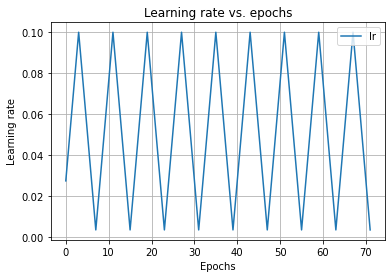

In [14]:
plot_lrs(history, None)